In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
# Load the dataset
df = pd.read_csv('Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [19]:
# Step 1: Correlation Analysis
correlations = df.corr()
print("Correlation Coefficients with Gold Price:\n", correlations['Gold_Price'])

Correlation Coefficients with Gold Price:
 Gold_Price    1.000000
USD_Index    -0.401637
GDP           0.815445
Oil_Price     0.783434
Name: Gold_Price, dtype: float64


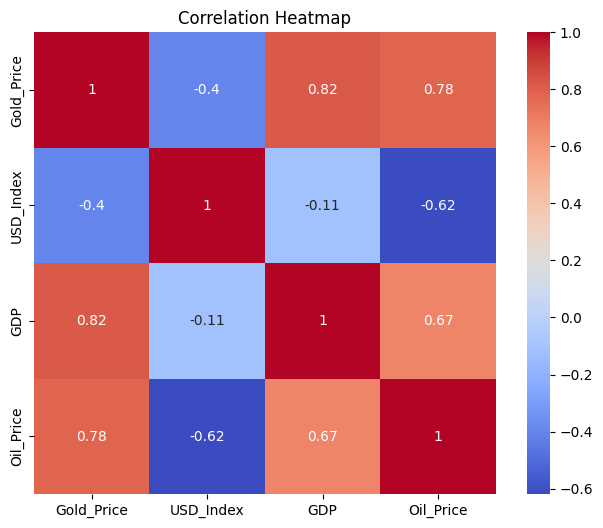

In [20]:
# Plotting correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

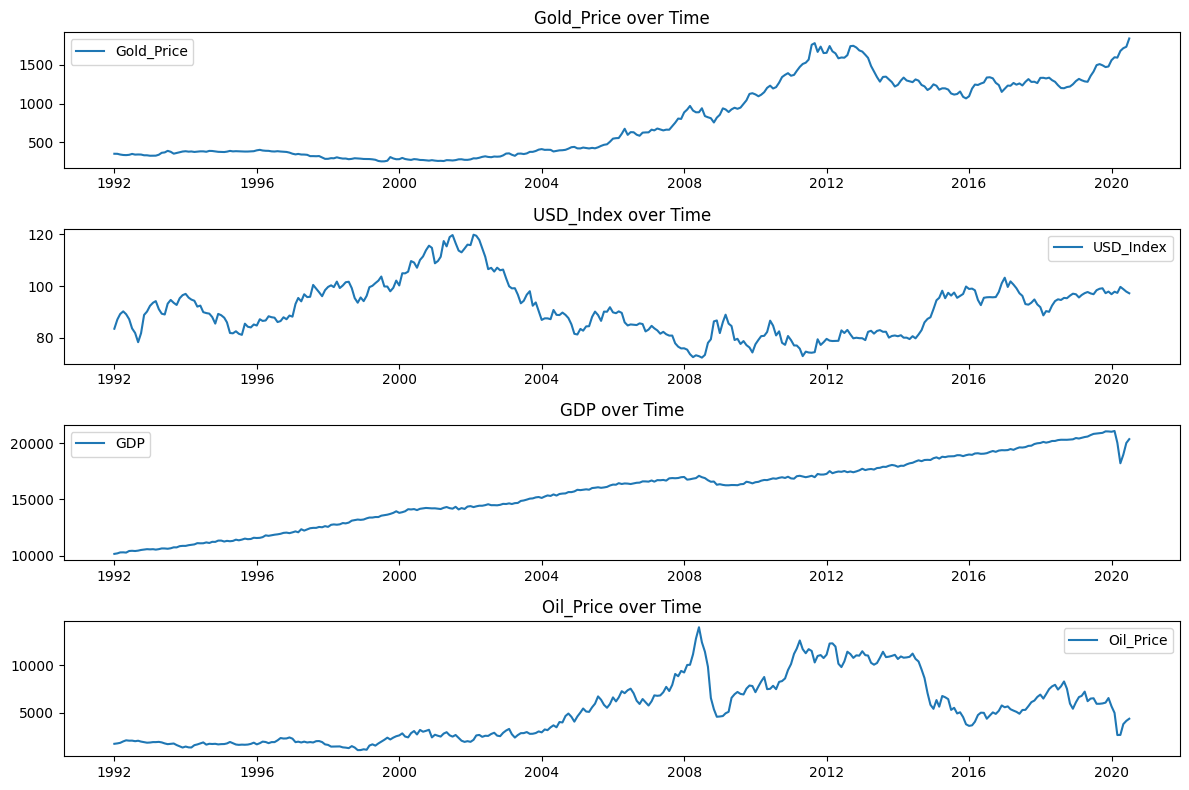

In [21]:

# Plot the original series for each variable
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i+1)
    plt.plot(df.index, df[col], label=col)
    plt.title(f'{col} over Time')
    plt.legend()
plt.tight_layout()
plt.show()

In [22]:

# Step 3: Stationarity Check using ADF Test
def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'Augmented Dickey-Fuller Test for {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print("Critical Values:")
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    print('')

In [23]:

# Check stationarity for each variable and apply differencing if necessary
for column in df.columns:
    adf_test(df[column], title=column)

Augmented Dickey-Fuller Test for Gold_Price
ADF Statistic: 0.07993979388284092
p-value: 0.9646645001705061
Critical Values:
	1%: -3.4502615951739393
	5%: -2.8703117734117742
	10%: -2.5714433728242714

Augmented Dickey-Fuller Test for USD_Index
ADF Statistic: -1.8986063427357465
p-value: 0.33271701486658456
Critical Values:
	1%: -3.4496162602188187
	5%: -2.870028369720798
	10%: -2.5712922615505627

Augmented Dickey-Fuller Test for GDP
ADF Statistic: -1.4518537756510457
p-value: 0.5571800950853137
Critical Values:
	1%: -3.449846029628477
	5%: -2.870129281376164
	10%: -2.5713460670144603

Augmented Dickey-Fuller Test for Oil_Price
ADF Statistic: -2.0805798105886613
p-value: 0.2523949124926398
Critical Values:
	1%: -3.449673193310592
	5%: -2.8700533746644323
	10%: -2.5713055939491403



In [24]:

# Differencing for non-stationary variables
df_diff = df.diff().dropna()
for column in df_diff.columns:
    adf_test(df_diff[column], title=column)

Augmented Dickey-Fuller Test for Gold_Price
ADF Statistic: -3.8849435418780622
p-value: 0.0021484913751765406
Critical Values:
	1%: -3.4502615951739393
	5%: -2.8703117734117742
	10%: -2.5714433728242714

Augmented Dickey-Fuller Test for USD_Index
ADF Statistic: -17.36721780183629
p-value: 5.162650582757661e-30
Critical Values:
	1%: -3.449673193310592
	5%: -2.8700533746644323
	10%: -2.5713055939491403

Augmented Dickey-Fuller Test for GDP
ADF Statistic: -11.488733131254419
p-value: 4.794056489864938e-21
Critical Values:
	1%: -3.449846029628477
	5%: -2.870129281376164
	10%: -2.5713460670144603

Augmented Dickey-Fuller Test for Oil_Price
ADF Statistic: -13.780331910131729
p-value: 9.322206038336554e-26
Critical Values:
	1%: -3.449673193310592
	5%: -2.8700533746644323
	10%: -2.5713055939491403



In [25]:
# Perform the ADF test specifically for Oil_Price
adf_test(df_diff['Oil_Price'], title="Oil_Price")

Augmented Dickey-Fuller Test for Oil_Price
ADF Statistic: -13.780331910131729
p-value: 9.322206038336554e-26
Critical Values:
	1%: -3.449673193310592
	5%: -2.8700533746644323
	10%: -2.5713055939491403



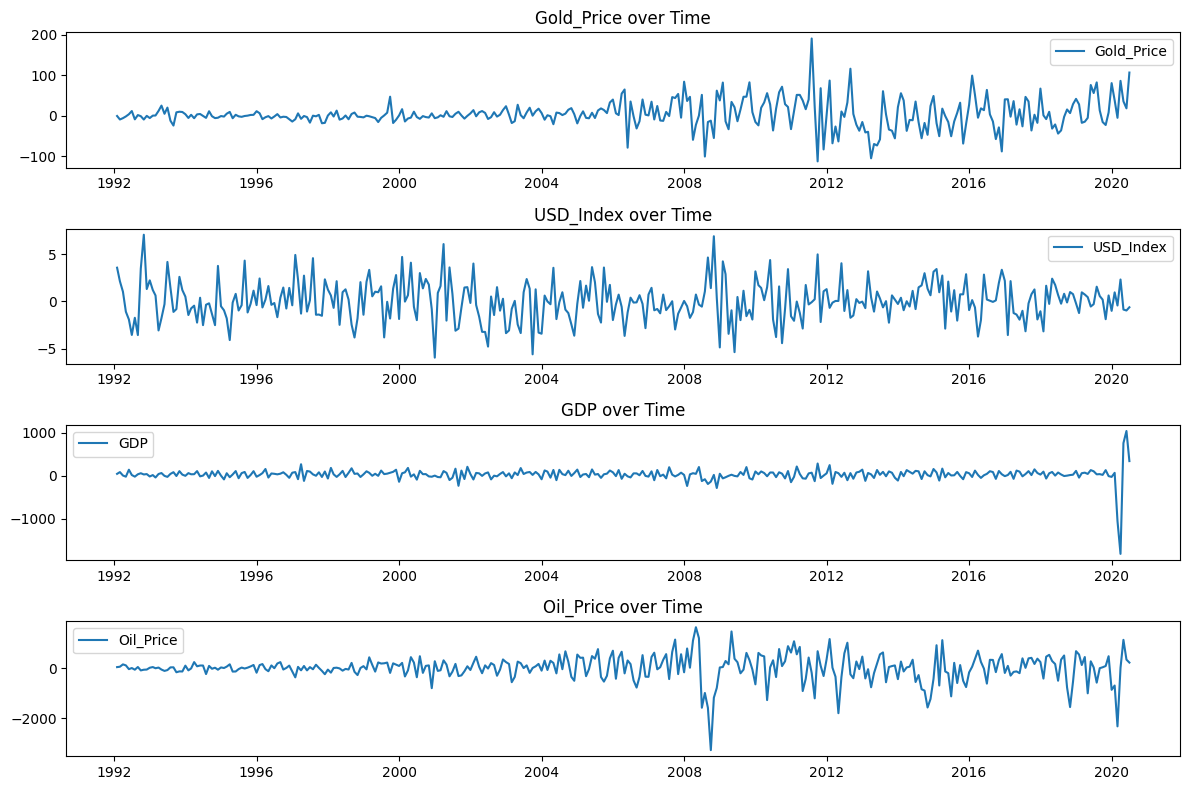

In [26]:

# Plot the original series for each variable after differencing
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_diff.columns):
    plt.subplot(len(df_diff.columns), 1, i+1)
    plt.plot(df_diff.index, df_diff[col], label=col)
    plt.title(f'{col} over Time')
    plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# Target and Exogenous Variables
target = 'Gold_Price'
exog_vars = ['USD_Index', 'GDP', 'Oil_Price']

In [28]:
# Step 4: Split into Train and Test
train_size = int(0.8 * len(df_diff))
y_train, y_test = df_diff[target][:train_size], df_diff[target][train_size:]
exog_train, exog_test = df_diff[exog_vars][:train_size], df_diff[exog_vars][train_size:]

In [29]:
# Scaling Exogenous Variables
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)

In [30]:
# Step 5: Use Auto ARIMA to find the best model order, with exogenous variables
auto_arima_model = auto_arima(y_train, exogenous=exog_train, seasonal=False, trace=True, error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2652.956, Time=5.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2663.629, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2656.390, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2655.880, Time=1.50 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2655.859, Time=2.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2655.608, Time=3.59 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2654.942, Time=5.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2654.943, Time=2.39 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2654.911, Time=0.31 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2656.211, Time=0.48 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2656.451, Time=2.82 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2658.293, Time=13.66 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2654.448, Time=8.16 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 46.854 seconds


In [31]:
# Extract the best order from the Auto ARIMA model
model_order = auto_arima_model.order
print(f"Best ARIMAX model order found by Auto ARIMA: {model_order}")

Best ARIMAX model order found by Auto ARIMA: (2, 0, 2)


In [32]:
# Train ARIMAX Model with the selected parameters
model = SARIMAX(y_train, exog=exog_train_scaled, order=model_order)
results = model.fit(disp=False)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting M

In [33]:
# Forecast
forecast = results.predict(start=len(y_train), end=len(df_diff)-1, exog=exog_test_scaled)

In [34]:
# Reverse Differencing to Reconstruct Actual Values
forecast_cumsum = np.cumsum(forecast) + df[target][train_size-1]
y_test_cumsum = np.cumsum(y_test) + df[target][train_size-1]
y_train_cumsum = np.cumsum(y_train) + df[target][0]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10248\2056053401.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_cumsum = np.cumsum(forecast) + df[target][train_size-1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10248\2056053401.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test_cumsum = np.cumsum(y_test) + df[target][train_size-1]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10248\2056053401.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

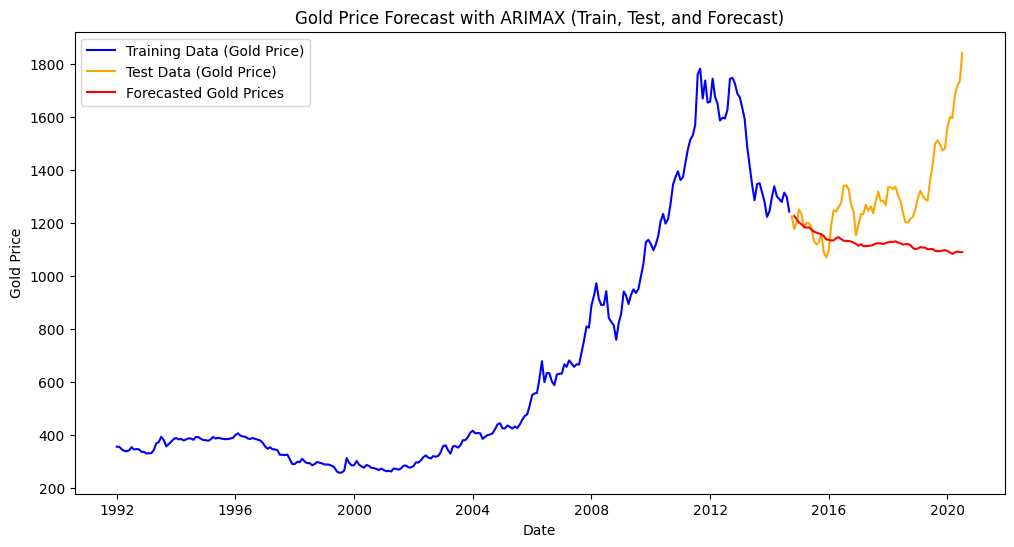

In [35]:
# Step 6

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df[target][:train_size], label='Training Data (Gold Price)', color='blue')
plt.plot(df[target][train_size:], label='Test Data (Gold Price)', color='orange')
plt.plot(y_test_cumsum.index, forecast_cumsum, label='Forecasted Gold Prices', color='red')
plt.title('Gold Price Forecast with ARIMAX (Train, Test, and Forecast)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()

In [36]:
# Step 7: Calculate Evaluation Metrics
# Evaluate Metrics
mae = mean_absolute_error(y_test_cumsum, forecast_cumsum)
mse = mean_squared_error(y_test_cumsum, forecast_cumsum)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_cumsum - forecast_cumsum) / y_test_cumsum)) * 100

# Display Results
print("\nEvaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Evaluation Metrics:
Mean Absolute Error (MAE): 202.6518998127609
Mean Squared Error (MSE): 70410.67706009881
Root Mean Squared Error (RMSE): 265.35010280777885
Mean Absolute Percentage Error (MAPE): 14.17740986412592%
